In [13]:
import h5py
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns
import copy

from tqdm import tqdm
import pandas as pd

import os

import nexusformat.nexus as nx

# f = nx.nxload("f:\\git\\eeg_prep\\me\\processed_files\\001_000500_000500.hdf5")

f = nx.nxload("/media/dan/Data/data/sourcesink_eegprep_calculations/processed_files/001_000500_000500.hdf5")
print(f.tree)

root:NXroot
  @date_created = '2024-09-23 17:14:40'
  @description = 'HDF5 file containing iEEG data and calculation...'
  data:NXgroup
    @description = 'windows are shaped (winsize_samps, len(channel...'
    A_mask = int32(609)
    A_mats = float64(118x118x609)
    A_mean = float64(118x118x1)
    A_medians = float64(609)
    A_thresh = -0.06341795947623834
    window_indexs = int32(609x2)
    window_reconstructionError = float64(609)
    windows = float64(512x118x609)
  metadata:NXgroup
    N_samples = 312064
    N_wins = 609
    STEPSIZE_MSEC = 500
    STEPSIZE_SAMPS = 512
    WINSIZE_MSEC = 500
    WINSIZE_SAMPS = 512
    channels = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', '...
    patient_info:NXgroup
      aal = ['ParaHippocampal_R', 'Hippocampus_R', 'Hippocampus_R', ...
      aal2 = ['ParaHippocampal_R', 'Hippocampus_R', 'Hippocampus_R', ...
      age_days_at_recording = float64(118)
      age_years_at_recording = float64(118)
      bad_channel = ['False', 'False'

In [2]:
def drop_connections_until_split(adj_matrix, remove_type='lowest', directed=False):
    """
    Removes connections from the adjacency matrix based on the specified remove_type
    ('lowest' or 'highest' absolute values) until the graph splits into multiple
    connected components.

    Parameters:
    - adj_matrix (np.ndarray): Square adjacency matrix.
    - remove_type (str): 'lowest' to remove weakest connections first,
                         'highest' to remove strongest connections first.
    - directed (bool): Whether the graph is directed.

    Returns:
    - np.ndarray: Modified adjacency matrix with certain connections set to zero.
    """
    # Validate remove_type
    if remove_type not in ['lowest', 'highest']:
        raise ValueError("remove_type must be either 'lowest' or 'highest'.")

    # Ensure the adjacency matrix is a NumPy array
    abs_matrix = np.abs(np.array(copy.deepcopy(adj_matrix)))
    
    # Create a NetworkX graph from the adjacency matrix
    if directed:
        G = nx.from_numpy_array(abs_matrix, create_using=nx.DiGraph)
    else:
        G = nx.from_numpy_array(abs_matrix)
    
    # Define the connectivity check based on graph type
    if directed:
        connectivity_func = nx.is_strongly_connected
        # connectivity_func = nx.is_connected
    else:
        connectivity_func = nx.is_connected

    # If the graph is already disconnected, return as is
    if not connectivity_func(G):
        print("The input graph is already disconnected.")
        return adj_matrix
    
    # Get all edges with their absolute weights
    edges = list(G.edges(data=True))
    # Sort edges based on absolute weight
    if remove_type == 'lowest':
        edges_sorted = sorted(edges, key=lambda x: abs(x[2]['weight']))
    else:  # remove_type == 'highest'
        edges_sorted = sorted(edges, key=lambda x: abs(x[2]['weight']), reverse=True)
    
    # print(edges_sorted)

    # Iterate through sorted edges and remove them one by one
    for u, v, data in edges_sorted:
        # Remove the edge
        G.remove_edge(u, v)
        
        # Check if the graph is still connected
        still_connected = connectivity_func(G)
        
        if not still_connected:
            # If removing this edge disconnects the graph, add it back and stop
            G.add_edge(u, v, weight=data['weight'])
            print(f"Stopping removal. Removing edge ({u}, {v}) would disconnect the graph.")
            break
        else:
            # If still connected, set the corresponding entry in adj_matrix to zero
            adj_matrix[u, v] = 0
            if not directed:
                adj_matrix[v, u] = 0  # For undirected graphs
    
    return G, adj_matrix


In [14]:
hdf5_path = "F:\\git\\eeg_prep\\me\\processed_files"
hdf5_path = "/media/dan/Data/git/eeg_prep/processed_files"

files = os.listdir(hdf5_path)
    
# load all files into individual lists
channels = {}
brainnetome = {}
harvard_oxford = {}
miccai = {}
aal = {}
white_matter = {}
soz = {}
ilae = {}
pids = []
a_mats = {}
a_masks = {}
raw_data = {}


for f in tqdm(files):
    if f.endswith(".hdf5"):
        pid = int(f.split("_")[0])
        pids.append(pid)
        with h5py.File(os.path.join(hdf5_path,f), "r") as f:
            channels[pid] = f['metadata']["channels"][:]
            brainnetome[pid] = f['metadata']['patient_info']["brainnetome"][:]
            harvard_oxford[pid] = f['metadata']['patient_info']["harvard-oxford"][:]
            miccai[pid] = f['metadata']['patient_info']["miccai"][:]
            aal[pid] = f['metadata']['patient_info']["aal"][:]
            white_matter[pid] = f['metadata']['patient_info']["white_matter"][:].astype(bool)
            # convert from bytes to string
            channels[pid] = [x.decode('utf-8') for x in channels[pid]]
            brainnetome[pid] = [x.decode('utf-8') for x in brainnetome[pid]]
            harvard_oxford[pid] = [x.decode('utf-8') for x in harvard_oxford[pid]]
            miccai[pid] = [x.decode('utf-8') for x in miccai[pid]]
            aal[pid] = [x.decode('utf-8') for x in aal[pid]]

            soz[pid] = f['metadata']["patient_info"]['soz'][:].astype(bool)
            ilae[pid] = f['metadata']["patient_info"]['ilae'][:]

            a_mats[pid] = f['data']['A_mats'][:]
            a_masks[pid] = f['data']['A_mask'][:].astype(bool)
            raw_data[pid] = f['data']['windows'][:]

100%|██████████| 72/72 [04:30<00:00,  3.76s/it]


In [163]:
aal_flat = {}
for k,v in aal.items():
    # remove "_R" or "_L" from the region names. it should always be the last 2 characters but may not always be present
    aal_flat[k] = [x[:-2] if x[-2:] in ["_R","_L"] else x for x in v]


In [21]:


def zero_one_normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))


df = pd.DataFrame(columns=['pid', 'channel', 'brainnetome', 'harvard-oxford', 'miccai','aal','white_matter', 'soz', 'ilae', 'row_mag_sum', 'row_mag_avg', 'row_mag_med',
                                                            'row_dis_sum', 'row_dis_avg', 'row_dis_med',
                                                            'row_dis_sumAbs', 'row_dis_avgAbs', 'row_dis_medAbs',
                                                            'col_mag_sum', 'col_mag_avg', 'col_mag_med',
                                                            'col_dis_sum', 'col_dis_avg', 'col_dis_med',
                                                            'col_dis_sumAbs', 'col_dis_avgAbs', 'col_dis_medAbs'])
for pid in tqdm(pids):
    mask = a_masks[pid].astype(bool)
    diffs = np.diff(a_mats[pid][...,mask], axis=-1)
    break
#     tot_mag = np.sum(np.abs(diffs), axis=-1)
#     # normalize 0-1
#     tot_mag = tot_mag / np.max(tot_mag)

#     displacement = np.sum(diffs, axis=-1)

#     # normalize 0-1
#     displacement = displacement / np.max(np.abs(displacement))

#     s = soz[pid]
#     b = brainnetome[pid]
#     h = harvard_oxford[pid]
#     mic = miccai[pid]
#     aa = aal[pid]
#     w = white_matter[pid]
#     # calculate soz + 1. visually the hotspots were often off by 1. expand anywhere there is a soz so the contact before and after are included
#     mask = np.where(s)[0]
#     s2 = np.copy(s)
#     m1= mask-1
#     m2= mask+1
#     # check bounds
#     m1[m1<0] = 0
#     m2[m2>=len(s)] = len(s)-1
#     np.put(s2, m1, True)
#     np.put(s2, m2, True)
#     c = channels[pid]
#     i = ilae[pid]
#     rows = []

#     for x in range(len(c)):
#         row_mag_sum = np.sum(tot_mag[x,:])
#         row_mag_avg = np.mean(tot_mag[x,:])
#         row_mag_med = np.median(tot_mag[x])

#         row_dis_sum = np.sum(displacement[x,:])
#         row_dis_avg = np.mean(displacement[x,:])
#         row_dis_med = np.median(displacement[x,:])

#         row_dis_sumAbs = np.sum(np.abs(displacement[x,:]))
#         row_dis_avgAbs = np.mean(np.abs(displacement[x,:]))
#         row_dis_medAbs = np.median(np.abs(displacement[x,:]))

#         col_mag_sum = np.sum(tot_mag[:,x])
#         col_mag_avg = np.mean(tot_mag[:,x])
#         col_mag_med = np.median(tot_mag[:,x])

#         col_dis_sum = np.sum(displacement[:,x])
#         col_dis_avg = np.mean(displacement[:,x])
#         col_dis_med = np.median(displacement[:,x])

#         col_dis_sumAbs = np.sum(np.abs(displacement[:,x]))
#         col_dis_avgAbs = np.mean(np.abs(displacement[:,x]))
#         col_dis_medAbs = np.median(np.abs(displacement[:,x]))
        

#         rows.append({'pid':pid, 'channel':c[x], 'brainnetome':b[x], 'harvard-oxford':h[x], 'miccai':mic[x], 
#                         'aal':aa[x], 'white_matter':w[x], 'soz':s[x], 'soz2':s2[x],'ilae':i[x], 
#                         'row_mag_sum':row_mag_sum, 'row_mag_avg':row_mag_avg, 'row_mag_med':row_mag_med,
#                         'row_dis_sum':row_dis_sum, 'row_dis_avg':row_dis_avg, 'row_dis_med':row_dis_med,
#                         'row_dis_sumAbs':row_dis_sumAbs, 'row_dis_avgAbs':row_dis_avgAbs, 'row_dis_medAbs':row_dis_medAbs,
#                         'col_mag_sum':col_mag_sum, 'col_mag_avg':col_mag_avg, 'col_mag_med':col_mag_med,
#                         'col_dis_sum':col_dis_sum, 'col_dis_avg':col_dis_avg, 'col_dis_med':col_dis_med,
#                         'col_dis_sumAbs':col_dis_sumAbs, 'col_dis_avgAbs':col_dis_avgAbs, 'col_dis_medAbs':col_dis_medAbs})
#     df = pd.concat([df, pd.DataFrame(rows)], ignore_index=True)


# df_grouped = df.groupby('pid')

# normalized_rows = []
# for pid, group in df_grouped:
#     group_normalized = group.copy()
#     columns_to_normalize = [
#         'row_mag_sum', 'row_mag_avg', 'row_mag_med',
#         'row_dis_sum', 'row_dis_avg', 'row_dis_med',
#         'row_dis_sumAbs', 'row_dis_avgAbs', 'row_dis_medAbs',
#         'col_mag_sum', 'col_mag_avg', 'col_mag_med',
#         'col_dis_sum', 'col_dis_avg', 'col_dis_med',
#         'col_dis_sumAbs', 'col_dis_avgAbs', 'col_dis_medAbs'
#     ]
#     for col in columns_to_normalize:
#         group_normalized[col] = zero_one_normalize(group[col])
#     normalized_rows.append(group_normalized)

# # Concatenate all normalized groups back into a single dataframe
# df_normalized = pd.concat(normalized_rows, ignore_index=True)

  0%|          | 0/72 [00:00<?, ?it/s]


In [153]:
from upsetplot import plot as uplot
from upsetplot import from_memberships

In [182]:
# get all unique flat regions
all_regions = set()
for k,v in aal_flat.items():
    all_regions.update(v)
    

In [189]:
q

Angular  Calcarine  Cingulum_Ant  Cingulum_Mid  Cuneus  Frontal_Inf_Tri  Frontal_Mid  Frontal_Sup  Frontal_Sup_Medial  Fusiform  Hippocampus  Insula  ParaHippocampal  Parietal_Inf  Precentral  Precuneus  Putamen  Rolandic_Oper  SupraMarginal  Temporal_Inf  Temporal_Mid  Temporal_Sup  nan  
False    False      False         False         False   False            False        False        False               False     False        True    False            False         False       False      False    True           False          False         False         False         False    1
True     True       True          True          True    True             True         True         True                True      True         True    True             True          True        True       True     False          True           True          True          True          True     1
Name: ones, dtype: int64

In [187]:
type(q)

pandas.core.series.Series

In [220]:
# Calculate the maximum absolute value across all plots for consistent x-axis scaling
for pid in tqdm(pids):
    mask = a_masks[pid].astype(bool)
    white_matter_mask = ~white_matter[pid]
    diffs = np.diff(a_mats[pid][...,mask], axis=-1)
    diffs = diffs[np.ix_(white_matter_mask, white_matter_mask, range(diffs.shape[2]))] # Only consider non white matter contacts
    mag_diffs = np.sum(np.abs(diffs), axis=-1)
    max_abs_value = np.max(mag_diffs)
    i = ilae[pid][0]
    sns.set_style('whitegrid')
    # Plot with consistent x-axis limits
    s = soz[pid][white_matter_mask]
    a_mat = mag_diffs

    m = np.array(aal_flat[pid])
    s1 = np.array(soz[pid])
    q = from_memberships([m[s1], m[~s1]])
    
    # Generate and save the upset plot separately
    fig_upset = plt.figure(figsize=(6, 6))
    uplot(q, fig=fig_upset, orientation='vertical', sort_by="input", sort_categories_by="input")
    upset_image_path = f"upset.png"
    fig_upset.savefig(upset_image_path)
    plt.close(fig_upset)

    # Create a new figure with 3 subplots and load the upset plot image in the first subplot
    fig = plt.figure(figsize=(10, 15))

    ax1 = fig.add_subplot(3, 1, 1)
    ax2 = fig.add_subplot(3, 1, 2)
    ax3 = fig.add_subplot(3, 1, 3, sharex = ax2, sharey = ax2)
    ax = [ax1, ax2, ax3]

    # Load the upset plot image and display it in the first axis
    upset_img = plt.imread(upset_image_path)
    ax[0].imshow(upset_img)
    # ax[0].set_ylim(0, upset_img.shape[0])
    # ax[0].set_xlim(-100, upset_img.shape[1])
    ax[0].axis('off')  # Hide the axes for the image
    # ax[0].set_aspect('auto')

    # Plot KDE for each group and set consistent x-axis limits on the second and third axes
    x = a_mat[s, :][:, s]
    sns.kdeplot(x.flatten(), ax=ax[1], fill=True, cut=0, label='SOZ')

    x = a_mat[~s, :][:, ~s]
    sns.kdeplot(x.flatten(), ax=ax[1], fill=True, cut=0, label='non-SOZ')
    ax[1].set_title("KDE of SOZ vs non-SOZ contacts")
    ax[1].set_xlim(-max_abs_value, max_abs_value)
    ax[1].legend()

    x = a_mat[s, :][:, ~s]
    sns.kdeplot(x.flatten(), ax=ax[2], fill=True, cut=0, label='SOZ to non-SOZ')

    x = a_mat[~s, :][:, s]
    sns.kdeplot(x.flatten(), ax=ax[2], fill=True, cut=0, label='non-SOZ to SOZ')
    ax[2].set_title("KDE of within soz contacts")
    ax[2].set_xlim(-max_abs_value, max_abs_value)
    ax[2].legend()

    # Save the combined figure
    plt.tight_layout()
    plt.savefig(f"{i}_{pid:04}.png")
    plt.close()


  1%|▏         | 1/72 [00:00<00:43,  1.63it/s]/tmp/ipykernel_11882/579237536.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[2].legend()
 21%|██        | 15/72 [00:09<00:39,  1.45it/s]/tmp/ipykernel_11882/579237536.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[2].legend()
 22%|██▏       | 16/72 [00:10<00:38,  1.45it/s]/tmp/ipykernel_11882/579237536.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[2].legend()
 46%|████▌     | 33/72 [00:22<00:30,  1.27it/s]/tmp/ipykernel_11882/579237536.py:44: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disabl

In [5]:
Ga, a = drop_connections_until_split(diffs[:,:,0], remove_type='lowest', directed=True)
Gb, b = drop_connections_until_split(diffs[:,:,1], remove_type='lowest', directed=True)

Stopping removal. Removing edge (101, 0) would disconnect the graph.
Stopping removal. Removing edge (1, 54) would disconnect the graph.


In [6]:
# name nodes in the graph by index but append 0's to the front to make them 4 digits
# this is so the graph will be displayed in the correct order
Ga = nx.relabel_nodes(Ga, {k: f"{k:04}" for k in Ga.nodes()})

In [7]:
nx.write_gexf(Ga, "Ga.gexf")

In [8]:
networkx.write_gexf( G , path )

NameError: name 'networkx' is not defined

<Axes: >

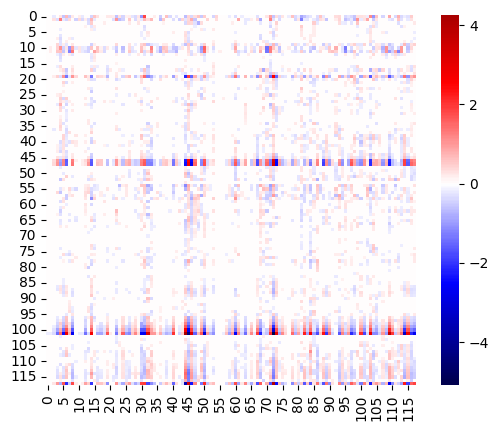

In [25]:
sns.heatmap(a, cmap='seismic', center=0,square=True)

<Axes: >

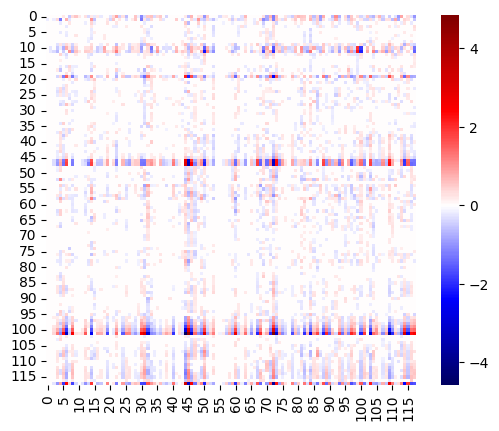

In [26]:
sns.heatmap(b, cmap='seismic', center=0,square=True)